## Predicting Heart Disease


### Introduction:

Heart disease is an umbrella term for a vast range of conditions that affect the heart. While there are many leading causes that can contribute to higher risks of heart disease, unhealthy lifestyle choices and genetics often play a large role. In Canada, heart disease is the second leading cause of death and a leading cause of hospitalization (Government of Canada, 2022). This statistic led us to wonder and study whether a predictive model can determine the presence of heart disease in a patient. Therefore, based on a data set from 1988 consisting of 4 databases from, Cleveland, Hungary, Switzerland, and Long Beach V, trends relating to heart disease will be used to predict the presence of the disease in individuals. 

This data was retrieved from the `heart_2.csv` file in the Heart Disease `project_data` folder, 
and was initially obtained from Kaggle: https://www.kaggle.com/datasets/johnsmith88/heart-disease-datasets


By observing the health reports of the patients in the data set, the five of the most influential factors in predicting the detection of heart disease in patients will be determined. From there, we will further investigate those variables further to determine the most significant of the five factors to include in a model to predict the presence of heart disease.

This will lead us to the question: **Can heart disease in a patient be predicted prior to diagnosis based upon the most influential factors within their health report?**

The goal of this project is to create a classification model that can accurately predict the presence of heart disease based on the most influential factors we determine. 

### Methods and Results:

Our general goal is to predict the `target` class by creating a K-NN Classification model with the optimal predictor variables that we will choose. Here are the steps that we will be taking to do this:


1. Read-in and tidy the data set: Make sure that the tidy data set criteria are all fulfilled.
2. Train/Test split: Split the data set into training and testing sets.
3. Analyze and summarize our training set: We will visualize the training data through the appropriate plots to see how the variables fluctuate and determine their relationship with the target variable.
4. Analyze predictor variables and select the ones of significance: We will create multiple recipes with different predictor variable combinations, and then analyze the resulting accuracy values from the cross-validations of each model to choose the most accurate one.
5. Find the optimal *k* value and build our final model.
6. Evaluation and Conclusion

### 1. Reading and Wrangling the Dataset
To begin our analysis we first loaded in the libraries that we would be using. Then, using `read_csv`, we first read in our dataset to better explore the variables and their relationship to the `target` variable, indicating the absence of heart disease, 0, and the presence of heart disease, 1. We then selected `age`, `exang`, `chol`, `thalach`, and `trestbps` as the variables we wanted to investigate. To check if there were missing values in the data set the `sum(is.na())` function was used.

In [15]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(GGally)


url = 'https://raw.githubusercontent.com/jennywyzhao/dsci-group-project-002-14/main/project_data/heart.csv'
download.file(url, destfile = "project_data/heart_2.csv")
heart_data <- read_csv("project_data/heart_2.csv")|>
 mutate(target = as_factor(target))

print("Table 1.1 Heart Data from Kaggle")
slice(heart_data, 1:5)

heart_var <- heart_data |>
    select(age, exang, chol, thalach, trestbps, target)

print("Table 2.1 Selected Variables for Investigation")

slice(heart_var, 1:5)
sum(is.na(heart_data))

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1.1 Heart Data from Kaggle"


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


[1] "Table 2.1 Selected Variables for Investigation"


age,exang,chol,thalach,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,0,212,168,125,0
53,1,203,155,140,0
70,1,174,125,145,0
61,0,203,161,148,0
62,0,294,106,138,0


[1] 0

The `age` factor was selected as, there tends to be a positive correlation between age and instances of heart disease (NIH, 2023). Exercise induced angina, `exang`, is a type of chest pain caused by elevated heart rate, and was chosen because, angina is often a symptom of heart disease (Department of Health & Human Services, 2001). Serum cholesterol level, `chol` was chosen to be investigated as, there is a positive correlation between elevated cholesterol levels and the risk of developing heart disease (Mayo Clinic, 2023). Maximum heart rate achieved, `thalach`, was chosen as each age group has an ideal heart rate range that when exceeded, can increase the risks of heart disease (Healthline, 2023). Resting blood pressure, `trestbps`, was chosen since, there tends to be a positive relationship with elevated resting blood pressure and the risks of developing heart disease (Mayo Clinic, 2022).

### 2. Splitting the Data
From here, we split the data with the selected variables into a training set with 75% of the data, and a testing set with 25% of the data. To make sure the data is reproducible, we will be using 3456 as our seed number.

In [16]:
set.seed(3456)

heart_split <- initial_split(heart_var, prop = 0.75, strata = target)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

### 3. Analyzing and Summarizing the Training Data

As our total dataset contains 1025 instances, and since our training set is 75% of that, there will be 768 instances in the training set.

In [17]:
n_for_target <- heart_train |>
    group_by(target) |>
    summarize(n = n())

print("Table 3.1: Distribution of Diagnoses")
n_for_target

[1] "Table 3.1: Distribution of Diagnoses"


target,n
<fct>,<int>
0,374
1,394


By using `group_by()` with num as its parameter, and `summarize()` with `n = n()` as its parameter, a tibble that contains the number of instances for each `target` type is created.

In `Table 3.1`, the ratio between the presence of heart disease (`target` = 1) vs. without heart disease (`target` = 0) is found to be nearly 1:1. 

In [18]:
mean_per_diagnosis <- heart_train |>
    group_by(target) |>
    summarize(mean_age = mean(age), mean_exang = mean(exang), mean_chol = mean(chol), mean_thalach = mean(thalach), mean_trestbps = mean(trestbps))
print("Table 3.2: Mean of Variables Across Diagnoses")
mean_per_diagnosis

[1] "Table 3.2: Mean of Variables Across Diagnoses"


target,mean_age,mean_exang,mean_chol,mean_thalach,mean_trestbps
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,56.64171,0.5454545,252.2112,139.6578,134.3583
1,52.74619,0.1370558,242.9898,158.0482,129.0482


Again, `group_by()` and `summarize()` are used to group the data by their `target` diagnoses, and then to find the means of all the data within those subgroups.

* We can see that in Table 3.2, patients with a `target` = 0 are on average, only around 4 years older than patients who have `target` = 1.
* Angina induced by exercise (`exang`), seems to be in a negative relationship with the diagnoses.
* The maximum heart rate of a patient (`thalach`) is higher for patients without heart disease compared to patients who do. This could mean that thalach could help determine if a patient's `target` value is 1 (has heart disease). 
* It seems that many of the values across diagnoses seem to have similar or slightly different mean values, which may be a point of concern for our model.

#### Visualizing the predictor variables
To better understand the relationships between the variables, we chose to use box plots and stacked bar graphs. In this way, we can see the mean values for variables alongside the rang of values where there is a presence of heart disease, when `target` is 1, and when there is no heart disease, when the `target` is 0. Since the `target` variable only has two possible values, we decided to plot `target` on the x-axis.

[1] "Figure 3.3: Variable Distributions Across Diagnosis"


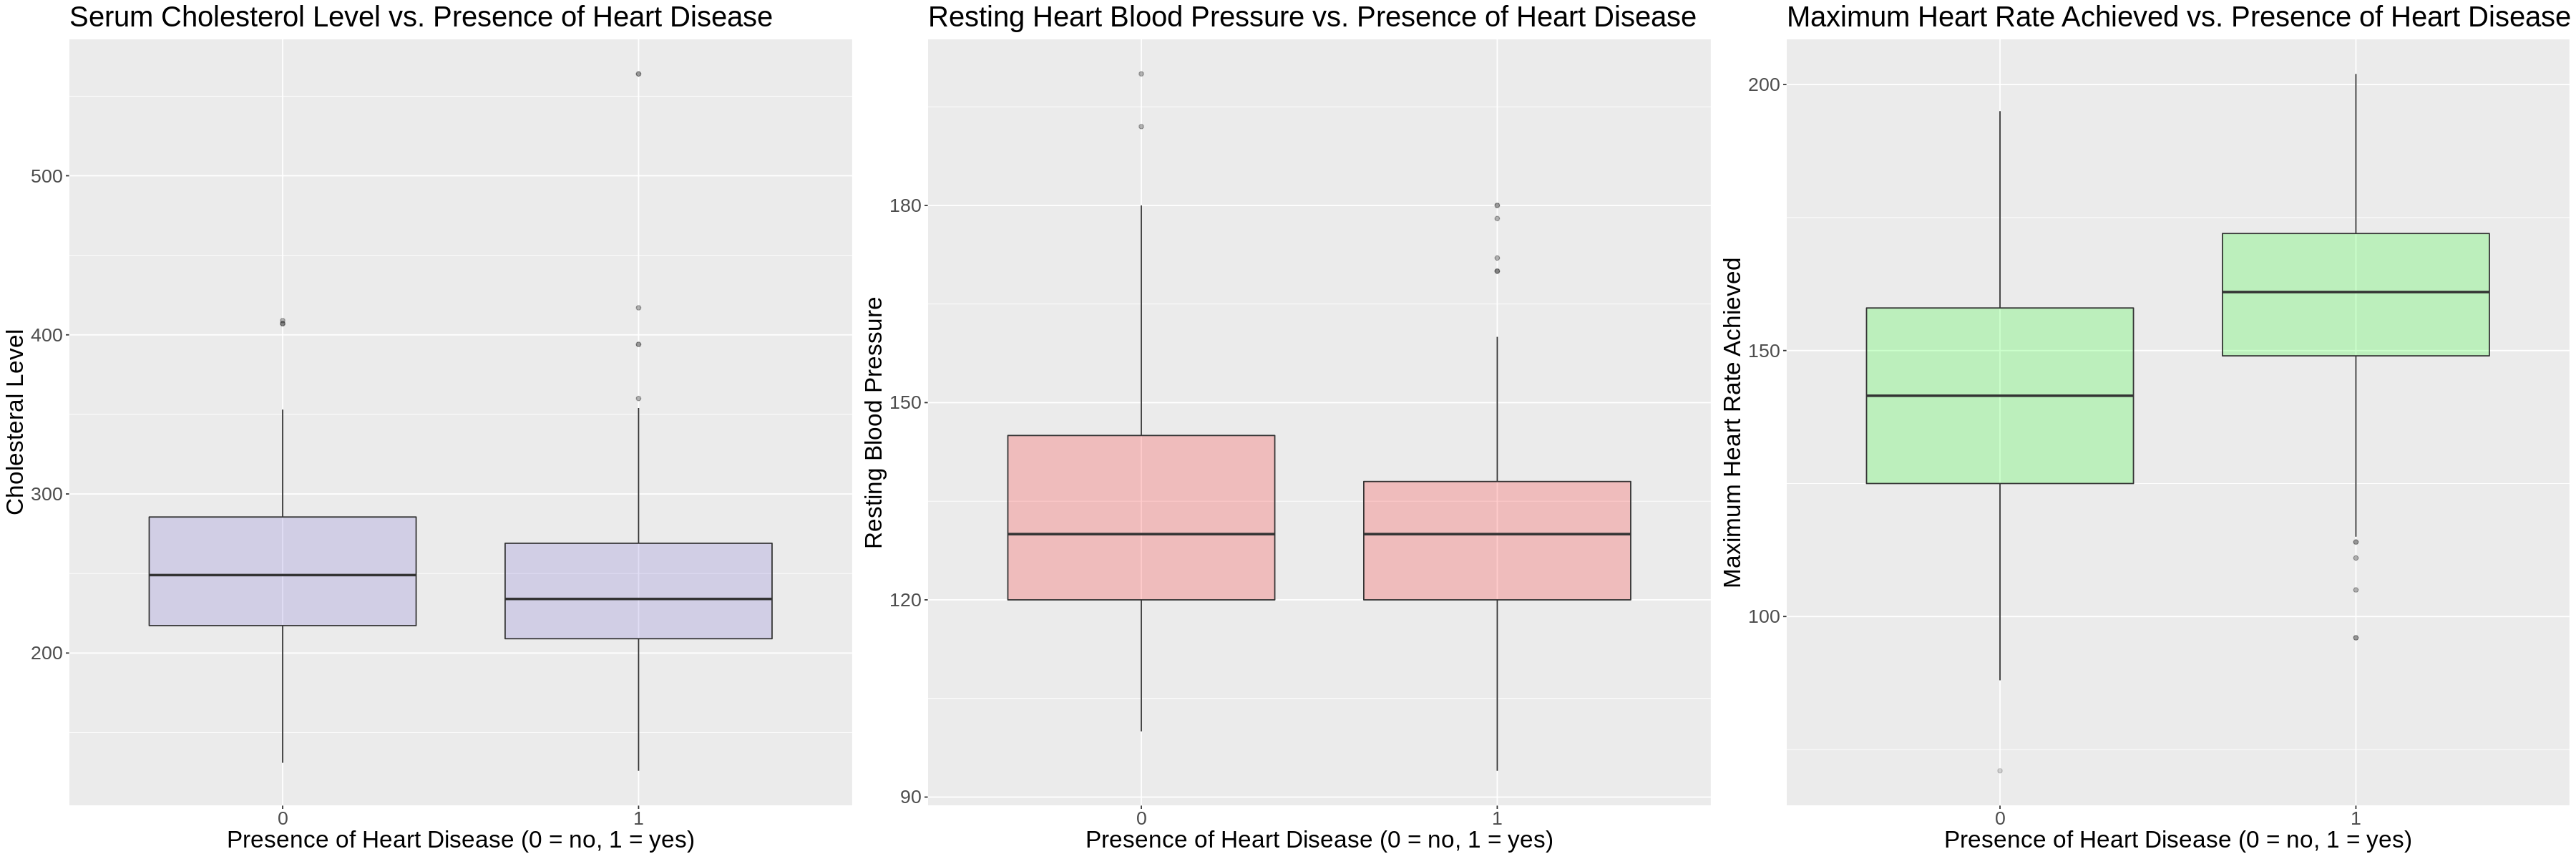

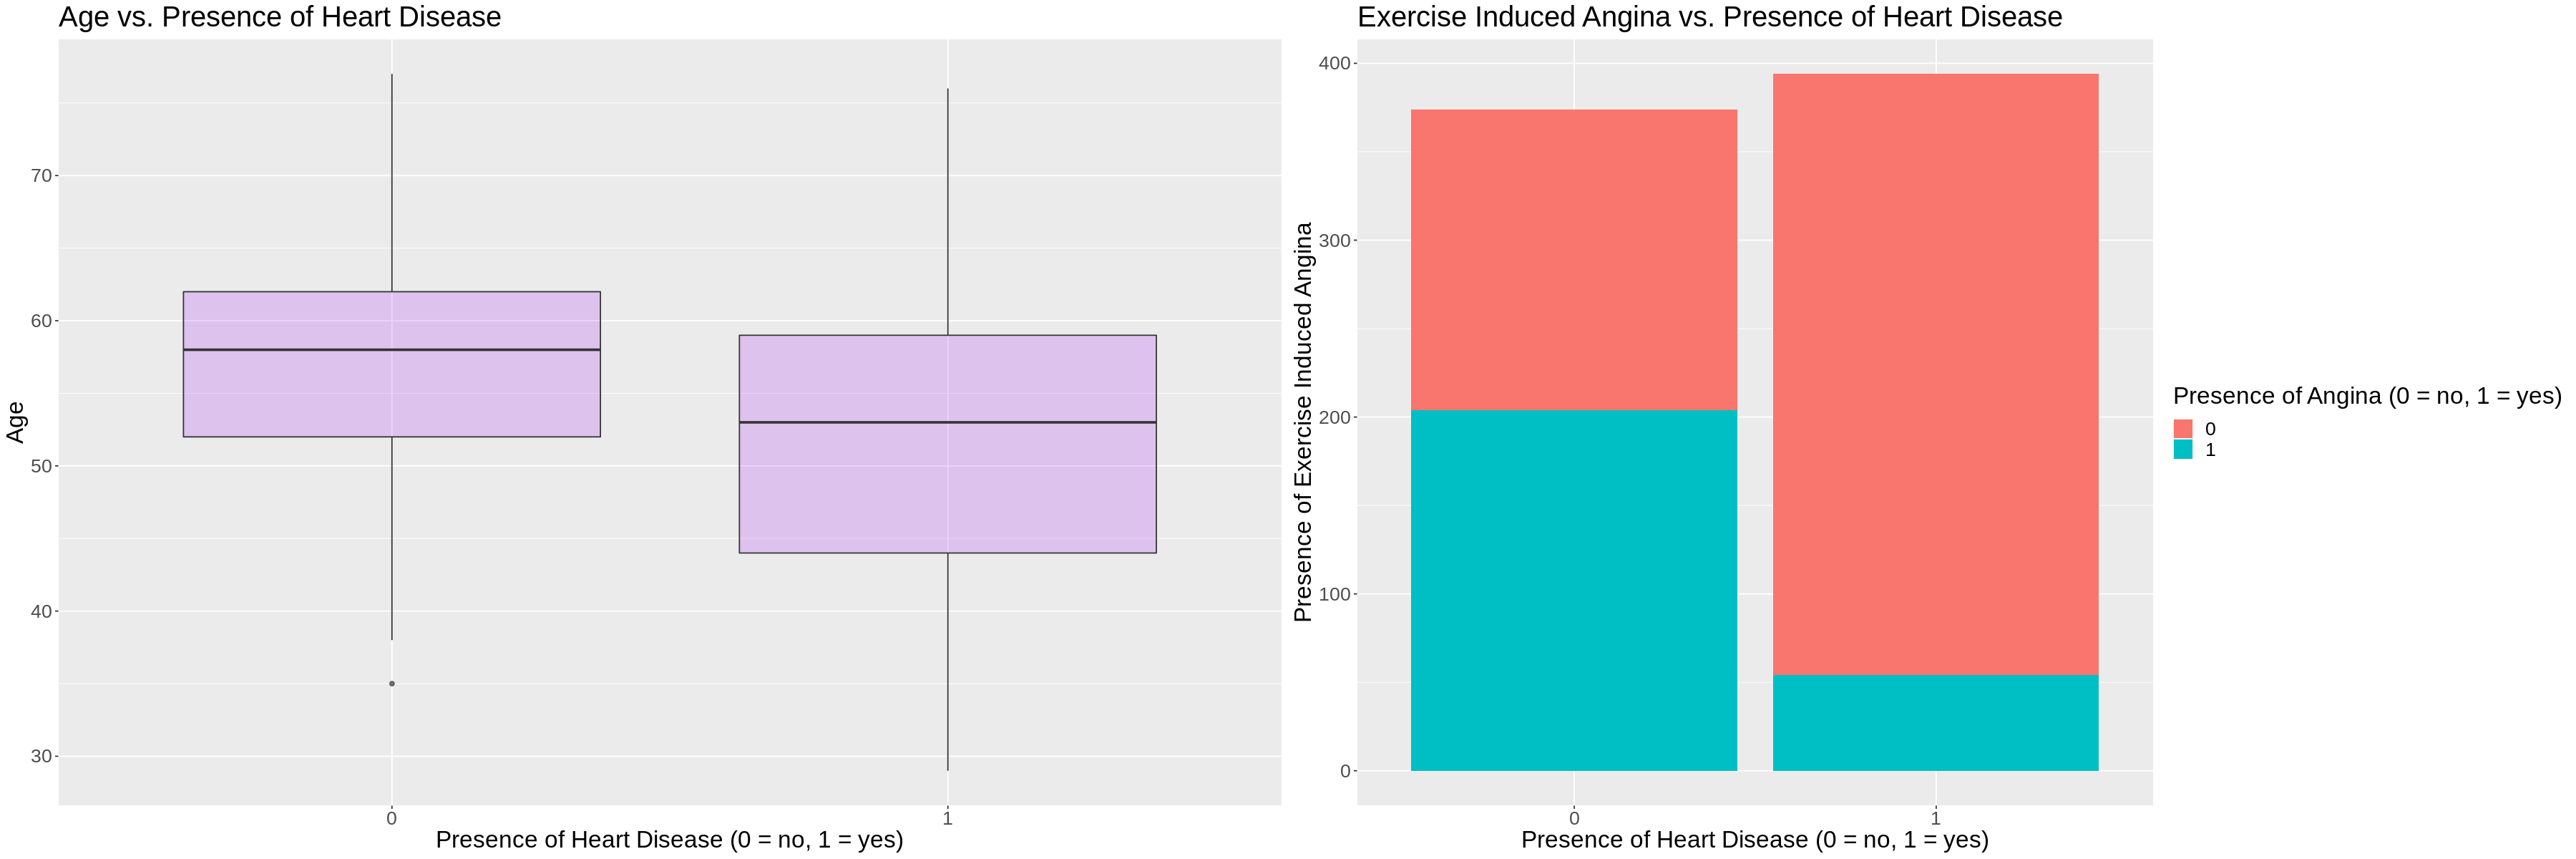

In [19]:
options(repr.plot.width = 30, repr.plot.height = 10)
chol_plot <- ggplot(heart_train, 
     aes(y = chol, 
           x = as.factor(target))) +
     geom_boxplot(fill = "slateblue", alpha = 0.2)+
     labs(x = "Presence of Heart Disease (0 = no, 1 = yes)", y = "Cholesteral Level" )+
     theme(text = element_text(size = 20))+
     ggtitle("Serum Cholesterol Level vs. Presence of Heart Disease")

trestbps_plot<- ggplot(heart_train,
    aes(y = trestbps,
            x = as.factor(target))) +
    geom_boxplot(fill = "red", alpha = 0.2)+
    labs(x="Presence of Heart Disease (0 = no, 1 = yes)", y = "Resting Blood Pressure" )+
    theme(text = element_text(size = 20))+
    ggtitle("Resting Heart Blood Pressure vs. Presence of Heart Disease")

       
thalach_plot <- ggplot(heart_train,
        aes(y = thalach,
            x = as.factor(target))) +
    geom_boxplot(fill = "green", alpha = 0.2)+
    labs(x = "Presence of Heart Disease (0 = no, 1 = yes)", y = "Maximum Heart Rate Achieved" )+
    theme(text = element_text(size = 20))+
    ggtitle("Maximum Heart Rate Achieved vs. Presence of Heart Disease")

print("Figure 3.3: Variable Distributions Across Diagnosis")
grid.arrange(chol_plot, trestbps_plot, thalach_plot, ncol = 3)

age_plot<- ggplot(heart_train,
        aes(y = age,
            x = as.factor(target))) +
    geom_boxplot(fill = "purple", alpha = 0.2)+
    labs(x = "Presence of Heart Disease (0 = no, 1 = yes)", y = "Age" )+
    theme(text = element_text(size = 20))+
    ggtitle("Age vs. Presence of Heart Disease")

exang_plot <- ggplot(heart_train, aes(x = target, fill = as.factor(exang)))+
   geom_bar()+
   labs(x = "Presence of Heart Disease (0 = no, 1 = yes)", y = "Presence of Exercise Induced Angina")+
   theme(text = element_text(size = 20))+
   ggtitle("Exercise Induced Angina vs. Presence of Heart Disease")+
  scale_fill_discrete(name = "Presence of Angina (0 = no, 1 = yes)")

grid.arrange(age_plot, exang_plot, ncol = 2)

Referencing the serum cholesterol level plot, the mean levels for individuals with heart disease is slightly lower than that of individuals who do not have heart disease. This is surprising as, the general trend found through research is, higher serum cholesterol levels tend to increase risks of developing heart disease. Since the difference is small, it does not make sense to include it as a predictor variable.

Regarding resting blood pressure, there was not a large difference in the mean values between individuals with and without heart disease. Hence, there is a suggestion that there is not a strong correlation between high or low resting blood pressure values and the presence of heart disease. Thus, resting blood pressure is likely not a useful predictor variable for our model. In reference to the maximum heart rate achieved, there is a higher mean value for individuals with a presence of heart disease. This is supported by research which suggests that a higher resting heart rate could indicate an increased risk of developing heart disease. Thus, maximum heart rate achieved will likely be useful to include in our model.

Referencing the age plot, the mean age value is smaller among the individuals who have heart disease. Since there is a difference between the mean ages of individuals who do and do not have heart disease, we will be using it as a predictor in our model. In general, the risks of heart disease increases as one ages, making this result somewhat unexpected. This result could be due to the fact that individuals who do not have heart disease tending to live longer or, sampling error.

Overall, we did not observe that the trends shown by the plot were similar to trends typically found and understood in other research.

#### The predictor variables that we will test are: `age`, `thalach`, and `exang`.

### 4. Analyzing and Selecting Predictor Variables

To confirm the selection of predictor variables, we will tune models and create distinct recipes for each set of predictor variables, then compare the accuracy of the models.
We will set neighbors to `tune()` in our K-NN recipe in combination with 5-fold cross-validation so that each model that we compare will be at its optimal accuracy.
Note that *k* values used for the cross-validation will be values from 1 to 50.
For now, it is not too significant that the accuracy is maximized (if we have the best *k* value), as we are analyzing how a predictor variable affects the model.
The data must also be scaled and centered, as the ranges of variables are different.

In [20]:
heart_vfold <- vfold_cv(heart_train, v = 5, strata = target)

gridvals <- tibble(neighbors = seq(1, 50))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [21]:
h_recipe <- recipe(target ~ age, heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

h_results <- workflow() |>
    add_recipe(h_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

h_results_best <- h_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

In [22]:
ht_recipe <- recipe (target ~ age + thalach, heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

ht_results <- workflow() |>
    add_recipe(ht_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

ht_results_best <- ht_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

In [23]:
hto_recipe <- recipe (target ~ age + thalach + exang, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

hto_results <- workflow() |>
    add_recipe(hto_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

hto_results_best <- hto_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

In [24]:
model <- c("target ~ age", "target ~ age + thalach", "target ~ age + thalach + exang")
accuracies <- c(h_results_best, ht_results_best, hto_results_best)
acc_table <- tibble(`Recipe Input` = character(), Accuracy = numeric()) |>
    add_row(`Recipe Input` = model, Accuracy = accuracies)

print("Table 4.1: Resulting Accurracies of Different Predictor Variables")
acc_table

[1] "Table 4.1: Resulting Accurracies of Different Predictor Variables"


Recipe Input,Accuracy
<chr>,<dbl>
target ~ age,0.6172420
target ~ age + thalach,0.9310834
target ~ age + thalach + exang,0.9388927


From `Table 4.1`, we can conclude that all three of these predictor variables are meaningful and increase the prediction accuracy. Using just `age`, the prediction accuracy is roughly 62% which, makes `age` a significant predictor variable. With the inclusion of `thalach` and `exang`, the accuracy increases significantly. Thus, the recipe with all three predictor variables will be used to build our model. 

### 5. Finding the Optimal `k` Value and Building the Final Model

To begin, new components that need to be updated will be built for the final model. A new set of *k* values will need to be tested. We will thus tune our model with various *k* values, and pick the best one through a visualization. 

In [25]:
k_values <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

# heart_vfold, hto_recipe, and knn_spec are previously defined
patient_results <- workflow() |>
    add_recipe(hto_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_values) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

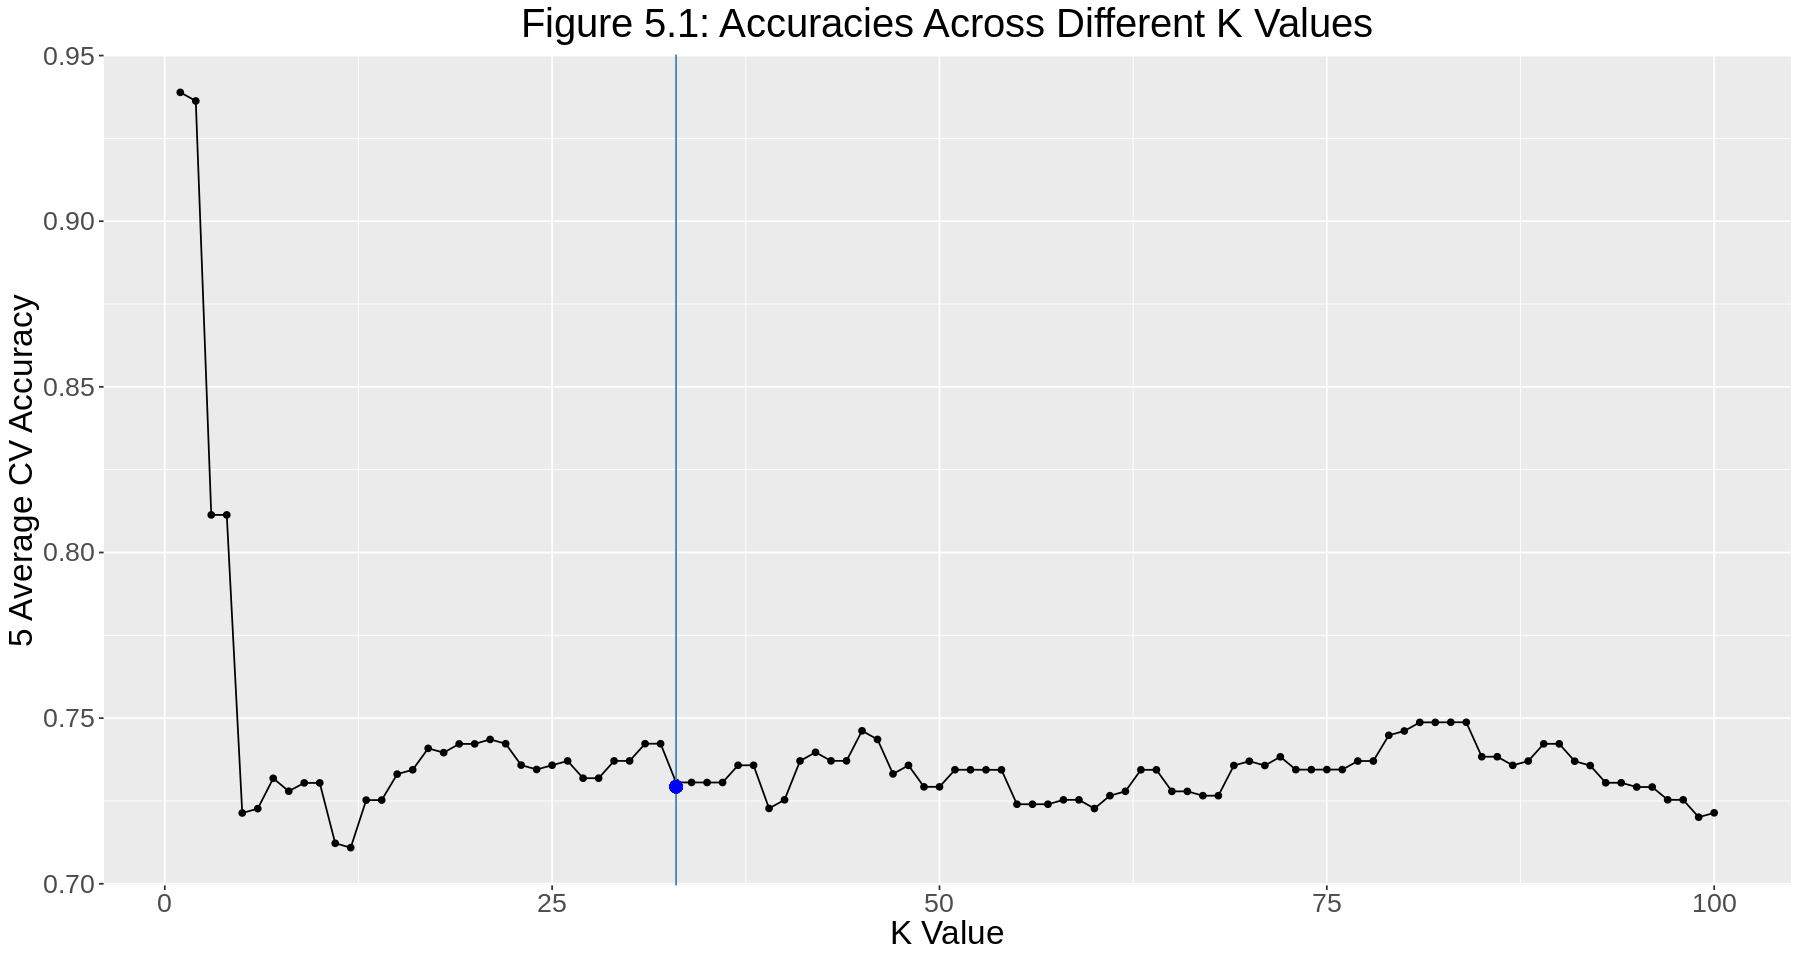

In [52]:
options(repr.plot.width = 15, repr.plot.height = 8)

best_k_y <- patient_results |>
    filter(neighbors == 50) |>
    pull(mean)

k_accuracies_plot <- patient_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 33, colour = "steelblue") +
    geom_point(aes(x = 33, y = best_k_y), size = 3, colour = "blue") +
    labs(x = "K Value", y = "5 Average CV Accuracy") +
    ggtitle("Figure 5.1: Accuracies Across Different K Values") +
    theme(text = element_text(size = 20)) +
    theme(plot.title = element_text(hjust = 0.5))

k_accuracies_plot

We can see in `Figure 5.1` that at `k = 33`, there is a three point plateau in the accuracy value that follows it. Since this is where the first plateau occurs, we will choose a value of *k* = 33 for our model.

#### Building the Final Model

Using our newly selected *k* value, we will build a new specification model as well as a new workflow.

In [53]:
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
  set_engine("kknn") |>
  set_mode("classification")

# hto_recipe is previously defined
patient_fit <- workflow() |>
    add_recipe(hto_recipe) |>
    add_model(best_knn_spec) |>
    fit(data = heart_train)

print("Figure 5.2: Final Classification Model")
patient_fit

[1] "Figure 5.2: Final Classification Model"


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(33,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2630208
Best kernel: rectangular
Best k: 33

#### 6. Model Evaluation and Conclusion

Now, by fitting our testing data set (`heart_test`) with `patient fit`, we will evaluate the model that has been created. 

In [54]:
patient_predictions <- predict(patient_fit, heart_test) |>
    bind_cols(heart_test)
patient_acc <- patient_predictions |>
    metrics(truth = target, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)

print("Table 6.1: Model Accuracy on the Testing Set")
patient_acc

[1] "Table 6.1: Model Accuracy on the Testing Set"


.metric,.estimate
<chr>,<dbl>
accuracy,0.766537


Here, we can see the final model's prediction accuracy is about 76.7% which, makes it decently reliable for prediction the heart disease in patients.

### Discussion:




In the end, we found the most significant predictors to be `age`, `thalach`, and `exang`, and the most optimal *k* value to be *k* = 33. This resulted in the final models prediction accuracy to be approximately 76.7%. Since the final accuracy was pretty high, this classifier could be useful for predicting the presence of heart disease. Regardless, it is important to remember that when put to use, the values for age, maximum heart rate achieved, and exercise induced angina may be less consistent with the values used to train and test this model. This will likely result in more frequent instances of miss-classification. 

During the initial researching stage, we found that as age increases, the risk for heart disease also increases as, the heart and its connecting blood vessels are also aging (NIH, 2023). This however was not the trend we found when looking at the mean values for individuals who do have heart disease which, was a lower age compared to individuals without heart disease. This finding may lead to researchers looking into a younger age group when trying to find ways to identify risks for developing heart disease. 

The maximum heart rate achieved was also found to be a significant factor in detecting the presence of heart disease. This brings to light how going over an individuals ideal maximum heart rate can also increase risks of heart disease. As supported by Healthline, going over the maximum heart rate for an individuals age group can be dangerous for ones health (Healthline, 2023). This particular finding highlighta the significance of knowing the maximum heart rate for an individual, and what a safe heart rate range is to reduce risks of developing heart disease.

Exercise induced angina was not found in high instances in patients with heart disease. This was quite surprising but, made it an effective predictor variable as, it was very infrequently found in individuals with heart disease. While unexpected, it elucidates the significance of the risks of heart disease, even in the absence of some of the telltale signs.

For the future, these findings may lead to different directions in research where the less expected predictors and parts of a health report can be used to determine risks of heart disease before a diagnosis is made. In turn, this may lead to questions of whether the current direction of research is the most effective, and if the stereotypical of a heart disease patient still holds true.

### References:


Canada, P. H. A. of. (2022, July 28). Government of Canada. Canada.ca. Retrieved April 9, 2023, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

Chertoff, J. (2023, February 23). Running heart rate: What's safe and what's too high? Healthline. Retrieved April 19, 2023, from https://www.healthline.com/health/running-heart-rate#:~:text=Going%20higher%20than%20your%20maximum,you're%20new%20to%20exercise.

Department of Health &amp; Human Services. (2001, May 18). Heart conditions - angina. Better Health Channel. Retrieved April 16, 2023, from https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/heart-conditions-angina 

Lapp, D. (2019, June 6). Heart disease dataset. Kaggle. Retrieved April 12, 2023, from https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download 

Mayo Foundation for Medical Education and Research. (2022, January 14). How high blood pressure can affect the body. Mayo Clinic. Retrieved April 16, 2023, from https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/high-blood-pressure/art-20045868#:~:text=High%20blood%20pressure%20can%20cause%20many%20heart%20problems%2C%20including%3A,arrhythmias)%20or%20a%20heart%20attack. 

Mayo Foundation for Medical Education and Research. (2022, March 30). Angina. Mayo Clinic. Retrieved April 9, 2023, from https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373#:~:text=During%20times%20of%20low%20oxygen,when%20exercising%2C%20angina%20can%20result. 

Mayo Foundation for Medical Education and Research. (2023, January 11). High cholesterol. Mayo Clinic. Retrieved April 16, 2023, from https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=With%20high%20cholesterol%2C%20you%20can,a%20heart%20attack%20or%20stroke. 

U.S. Department of Health and Human Services. (2018, June 1). Heart health and aging. National Institute on Aging. Retrieved April 12, 2023, from https://www.nia.nih.gov/health/heart-health-and-aging#:~:text=Adults%20age%2065%20and%20older,risk%20of%20developing%20cardiovascular%20disease. 